# Model Complexity

In [1]:
import random
import matplotlib.pyplot as plt
from numpy.random import normal

## 1. The Bias-Complexity Tradeoff

In [2]:
from numpy.random import beta as beta_sample
from numpy import linspace
from scipy.stats import beta
from scipy.optimize import minimize, brentq
import operator

### 1.1 Data Generation

In [17]:
# Number of examples per label
m = 1000

# Parameters for Beta distributions
alpha_1, beta_1 = 5, 1
alpha_2, beta_2 = 1, 2

# Draw examples and assign labels
x1 = list(beta_sample(alpha_1,beta_1,m))
y1 = [1]*m
# print(sorted(x1))
x2 = list(beta_sample(alpha_2,beta_2,m))
y2 = [-1]*m
# print(sorted(x2))

# Combine positive and negative examples
x = x1 + x2
y = y1 + y2

### 1.2 Data Visualization

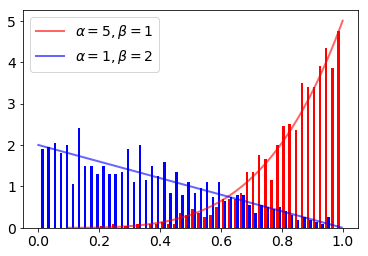

In [18]:
# Plot the examples
plt.hist([x1,x2], bins=50, color=['r','b'], density=True)

# PDF plot of Beta(x;4,1)
ls1 = linspace(beta.ppf(0.00001, alpha_1, beta_1),beta.ppf(0.99999, alpha_1, beta_1), 100)
plt.plot(ls1, beta.pdf(ls1, alpha_1, beta_1), 'r-', lw=2, alpha=0.6, label=r"$\alpha=5,\beta=1$")

# PDF plot of Beta(x;1,4)
ls2 = linspace(beta.ppf(0.00001, alpha_2, beta_2),beta.ppf(0.99999, alpha_2, beta_2), 100)
plt.plot(ls2, beta.pdf(ls2, alpha_2, beta_2), 'b-', lw=2, alpha=0.6, label=r"$\alpha=1,\beta=2$")

plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
# plt.savefig("fig-mix-beta.png")
plt.savefig("fig-mix-beta-samples.png")

### 1.3 Learning

In [19]:
def compute_empirical_risk(x, y, b):
    """
    x - input
    y - output
    b - dividing point
    """
    error_counts = 0.0
    for (idx,val) in enumerate(x):
        if (val <= b) and (y[idx] > 0):
            error_counts += 1
        elif (val > b) and (y[idx] < 0):
            error_counts += 1
            
    return error_counts/len(x)

def find_thresh(x, y, N=1000):
    """
    x - input
    y - output
    N - number of hypotheses
    """
    emp_errs, true_errs = {}, {}
    sorted_x = sorted(x)
    for idx in range(N):
        # if idx % 200 == 0:
        #     print(idx)
        b = (1.0*idx)/N
        # Empirical error
        emp_err = compute_empirical_risk(x, y, b)
        # True error of the same hypothesis
        true_err = 0.5*beta.cdf(b,alpha_1,beta_1) + 0.5*(1 - beta.cdf(b,alpha_2,beta_2))
        emp_errs[b] = emp_err
        true_errs[b] = true_err
    sorted_emp_errs = sorted(emp_errs.items(), key=operator.itemgetter(1))
    sorted_true_errs = sorted(true_errs.items(), key=operator.itemgetter(1))
    b, emp_err = sorted_emp_errs[0]
    bast, true_err = sorted_true_errs[0]
    return b, emp_err, true_errs[b], bast, true_err

def find_bayes_thresh():
    f = lambda x : beta.pdf(x,alpha_1,beta_1) - beta.pdf(x,alpha_2,beta_2)
    res = brentq(f, 0, 1)
    print(res)
    return res

def compute_bayes_error(b):
    bayes = 0.5*beta.cdf(b,alpha_1,beta_1) + 0.5*(1 - beta.cdf(b,alpha_2,beta_2))

In [20]:
# Learning on the sampled data

hs, hs_emp_err, hs_true_err, hast, hast_true_err = find_thresh(x, y, N=100)
print("h_S = {}\n\tEmpirical error L_S(h_S) = {}\n\tTrue error L_D(h_S) = {}\nh^ast={}\n\tTrue_error L_D(h^ast) = {}".format(hs, hs_emp_err, hs_true_err,hast, hast_true_err))

h_S = 0.65
	Empirical error L_S(h_S) = 0.11
	True error L_D(h_S) = 0.11926453124999997
h^ast=0.62
	True_error L_D(h^ast) = 0.11800664159999999


In [21]:
# Compute L_D(f_D)
b = find_bayes_thresh()

l_d_pos = 0.5*beta.cdf(b,alpha_1,beta_1) # Give the prob P(X<0.5)
l_d_neg = 0.5*(1 - beta.cdf(b,alpha_2,beta_2)) # Give the prob P(X>0.5)
bayes_err = l_d_pos + l_d_neg
print("L_D(f_D) = {}".format(bayes_err))

0.6231139899829601
L_D(f_D) = 0.11799012136737722


In [22]:
# Try different sizes of hypothesis spaces

E_app, E_est, E_total = [], [], []
for N in [100, 500, 1000, 2000, 5000, 10000]:
    hs, hs_emp_err, hs_true_err, hast, hast_true_err = find_thresh(x, y, N)
    E_app.append(hast_true_err - bayes_err)
    E_est.append(hs_true_err - hast_true_err)
    E_total.append(hs_true_err - bayes_err)
    print("N = {}, H_S true error = {}, E_app = {}, E_est = {}".format(N, hs_true_err, hast_true_err-bayes_err, hs_true_err-hast_true_err))

N = 100, H_S true error = 0.11926453124999997, E_app = 1.6520232622774245e-05, E_est = 0.0012578896499999825
N = 500, H_S true error = 0.118130677092912, E_app = 1.3434779347620829e-06, E_est = 0.0001392122476000235
N = 1000, H_S true error = 0.11816301762714651, E_app = 2.221229425392046e-08, E_est = 0.0001728740474750412
N = 2000, H_S true error = 0.11816301762714651, E_app = 2.221229425392046e-08, E_est = 0.0001728740474750412
N = 5000, H_S true error = 0.11816301762714651, E_app = 1.264901583475364e-08, E_est = 0.00017288361075346037
N = 10000, H_S true error = 0.1181664335572474, E_app = 3.3461369786103035e-10, E_est = 0.00017631185525648907


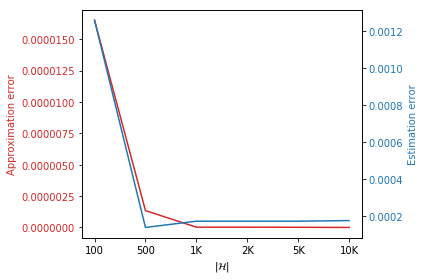

<Figure size 432x288 with 0 Axes>

In [24]:
fig, ax1 = plt.subplots()

color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('Approximation error', color=color)
ax1.set_xlabel(r'$|\mathcal{H}|$')
ax1.plot(range(len(E_app)), E_app, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Estimation error', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(E_est)), E_est, color=color)
# ax2.plot(range(len(E_total)), E_total, color='black')
ax2.tick_params(axis='y', labelcolor=color)

plt.setp(ax1, xticks=range(len(E_est)), xticklabels=["100", "500", "1K", "2K", "5K", "10K"])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.savefig("fig-decomp-plot.png")

# 2. The Bias-Variance Tradeoff

In [25]:
# Import necessary functions and packages

from numpy.random import normal, uniform
from numpy import sin

### 2.1 Data Generation

In [26]:
# Data generation functions

def poly(x):
    y = x + sin(2*x) # pow(x, 3) + pow(x,2)
    return y

def poly_noise(x, sigma=0.1):
    y = poly(x)
    return normal(y, sigma)

def generate_data(a=0.0, b=1.0, sigma=0.1, N=100):
    """
    a, b - left, right of the interval
    sigma - noise level
    N - number of samples
    """
    x = uniform(a, b, N)
    y = poly_noise(x, sigma) #  for val in x]
    return x, y

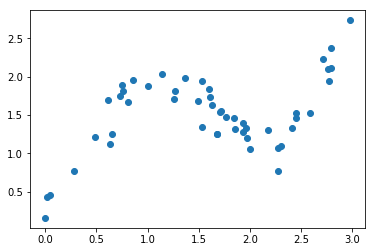

In [27]:
# Test the generation function
a, b = 0.0, 3.0
x, y = generate_data(a, b, 0.2, 50)
plt.plot(x,y,'o')
plt.savefig("fig-poly-data.png")

### 2.2 Polynomial Fit

In [28]:
from numpy import polyfit, poly1d, linspace, mean, array

In [29]:
def mse(f, x, y):
    """
    f - poly fitting function
    x, y - data input/output
    """
    errs = [pow(y-f(val),2) for val in x]
    return mean(errs)

0.456122016750707


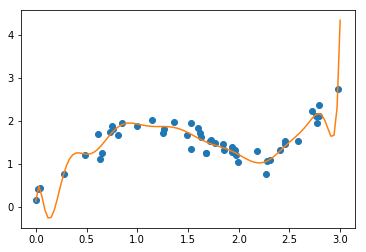

In [30]:
# Poly fitting 

degree = 15
w = polyfit(x,y,degree)
p_degree = poly1d(w)
# print(w)
xp = linspace(a, b, 100)
yp = [p_degree(val) for val in xp]
plt.plot(x,y,'o')
plt.plot(xp, yp)
plt.savefig("fig-poly-fit-d{}.png".format(degree))
print(mse(p_degree, x, y))

### 2.3 The Bias-Variance Tradeoff

In [33]:
# Configuration

S = 50 # Number of training sets
N = 100 # Number of training examples in each set
sigma = 0.8
a, b = 0, 3.0 # left/right end of the interval

# Sampling data sets

data = []
for sidx in range(S):
    x, y = generate_data(a, b, sigma, N)
    data.append({'x':x,'y':y})

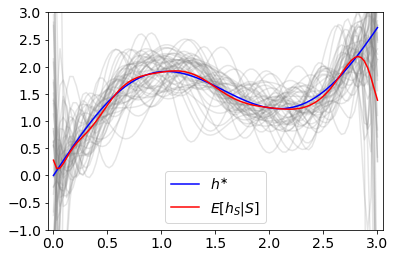

In [41]:
# Polynominal fitting

degree = 15 # degree of poly

func_list = []
for idx in range(S):
    w = polyfit(data[idx]['x'], data[idx]['y'], degree)
    func = poly1d(w)
    func_list.append(func)
    
# Plot

xp = linspace(a, b, 100)
yp_dict = {}

for val in xp:
    for sidx in range(S):
        try:
            yp_dict[sidx].append(func_list[sidx](val))
        except KeyError:
            yp_dict[sidx] = [func_list[sidx](val)]

yp_mean = None
for sidx in range(S):
    # print(yp_dict[sidx][:5])
    if yp_mean is None:
        yp_mean = array(yp_dict[sidx])
    else:
        yp_mean += array(yp_dict[sidx])
    plt.plot(xp, yp_dict[sidx], color='grey', alpha=0.2)
yp_mean = yp_mean/S
# print(yp_mean[:5])
    
plt.plot(xp, poly(xp), color='blue', label=r"$h^{\ast}$")
plt.plot(xp, yp_mean, color='red', label=r"$E[h_S|S]$")
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-1,3)
plt.xlim(-0.05,3.05)
plt.savefig("fig-bias-variance-d{}.png".format(degree))